# ROI-GUIDE

**R**egion-**O**f-**I**nterest **GU**ided **I**mage-quality **D**riven **E**xcitation Design

Use ROI image quality as loss to guide the RF pulse design. Optimzation framework for **single subject adaptation**.

Use low resolution excitation pattern to point-wise weight high resolution image.

In [2]:
import torch
import numpy as np
import scipy
import time
import os

In [3]:
import sys
sys.path.append('/home/yonglihe/github/HolisticMRI/mrphy_ss/')
#import mobjs
from mobjs import Pulse, SpinCube
import utils 
from mrphy import dt0, gmax0, smax0, rfmax0

In [4]:
from mirtorch.alg.cg import CG
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2dgram, Gmri, NuSenseGram

In [5]:
import matplotlib.pyplot as plt

In [6]:
import random

seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
def MaskL2(img1,img2,mask):
    r""" 
    img1/img2: [nbatch,*nM]
    mask: [nbatch, *nM]
    """
    err=img1-img2
    return (err*mask).norm()**2

def MSE(img1,img2,mask):
    err=img1-img2
    nM_roi=torch.sum(mask)

    mse=torch.sum((err*mask)**2)*(1/nM_roi)
    return mse

def PSNR(img1,img2,mask):
    mse=MSE(img1,img2,mask)
    psnr=10*torch.log10(torch.max(img1)**2/mse)
    return psnr

In [8]:
device0=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [113]:
class End2EndModel(torch.nn.Module):
    def __init__(self, tissue_path,pIni_path,sampling_pattern, roi, *, 
                rfmax=rfmax0, gmax=gmax0, smax=torch.tensor(15000),dt=dt0,
                noise_level=5e-6,
                device=device0,
                checkpoint_savepth='./checkpoint/'):
        r'''
        Inputs:
            - ```tissue_path```: path to the .npz file which has fields:
                - "I": ground truth image [nx,ny,nz]
                - "t1map": [nx,ny,nz]
                - "t2map":
                - "pdmap":
            - ```pIni_path```: path to the .npz file storing the initial RF pulse with fields:
                - "rf": [xy,nT]
                - "gr": [xyz,nT]
            - ```sampling_pattern```: tensor, (Cartesian, for now) acquisition pattern, [1,nx,ny,nz]
            - ```roi```: tensor, ROI mask, [1,nx,ny,nz]
        Optionals:
            - ```rfmax```: [Gauss], dflt=0.25, tensor, rf amplitude maximum by hardware limit, [1,]
            - ```gmax```: [Gauss/cm]], dflt=5, tensor, gradients maximum, [1,]
            - ```smax```: [Gauss/cm/sec], dflt=15e3, tensor, slew rate limit, [1,]
            - ```dt```: [sec],dflt=4e-6, tensor, raster time, [1,]
            - ```noise_level```: scalar, k space synthesized noise intensity
            
        '''
        super(End2EndModel, self).__init__()
        self.device=device
        self.checkpoint_savepth=checkpoint_savepth
        kw={'dtype': torch.float32, 'device':self.device}
        
        #hard-ware parameters
        self.rfmax,self.gmax,self.smax,self.dt=rfmax.to(device),gmax.to(device),smax.to(device),dt.to(device)
        
        #subject-specific tissue parameters
        data_npz=np.load(tissue_path)
        #self.Ireal = torch.tensor(data_npz["I"],**kw)
        self.t1map = torch.tensor(data_npz['t1map'],**kw)#*1e-3
        self.t2map = torch.tensor(data_npz['t2map'],**kw)#*1e-3 #unit to sec
        self.M0 = np.zeros(data_npz['pdmap'].shape+(3,)) #[nx,ny,nz,3]
        self.M0[...,2]=data_npz['pdmap'] 
        self.M0=torch.tensor(self.M0,**kw)
        
        #field inhomogeneity
        #############TODO###############
        
        #load the initial rf pulse
        pulse_npz=np.load(pIni_path)
        self.rf=torch.tensor(pulse_npz['rf']).unsqueeze(0).to(self.device)
        self.gr=torch.tensor(pulse_npz['gr']).unsqueeze(0).to(self.device)
        self.pIni=Pulse(rf=self.rf,gr=self.gr,rfmax=self.rfmax,gmax=self.gmax,smax=self.smax,
                       dt=self.dt,device=self.device)
        
        # Set up: Interior mapping, transform rf to (rho_tilde, theta_tilde), gr to s_tilde so as to enforce hard-ware limits, cf. tianrui's AutoDiff paper
        tρ, θ = utils.rf2tρθ(self.rf, self.rfmax)
        tsl = utils.s2ts(utils.g2s(self.gr, self.dt), self.smax)

        # enforce contiguousness of optimization variables, o.w. LBFGS may fail
        self.tρ, self.θ, self.tsl = tρ.contiguous(), θ.contiguous(), tsl.contiguous()

        self.tρ = torch.nn.Parameter(self.tρ) # Use nn.Parameter to enable optimization.
        self.θ= torch.nn.Parameter(self.θ)
        self.tsl=torch.nn.Parameter(self.tsl)
        
        # acquisition parameters
        self.noise_level=noise_level
        self.sampling_pattern=sampling_pattern.to(self.device)
        
        #optimizers
        self.opt_rf = torch.optim.LBFGS(list(self.parameters())[:2], lr=3., max_iter=20, history_size=30,
                 tolerance_change=1e-4,
                 line_search_fn='strong_wolfe') #optimizer for [rho, theta], aka rf #lr=3. before

        self.opt_sl = torch.optim.LBFGS([list(self.parameters())[2]], lr=3., max_iter=40, history_size=60,
                 tolerance_change=1e-6,
                 line_search_fn='strong_wolfe') #optimizer for slew, aka gradients #lr=3. before
#         self.opt_rf=torch.optim.Adam(list(self.parameters())[:2],lr=5e-3,amsgrad=True)
#         self.opt_sl=torch.optim.Adam([list(self.parameters())[2]],lr=5e-4,amsgrad=True)
        
        #ROI
        self.roi=roi.to(self.device)
        
    def forward(self):
        
        t1map=self.t1map.unsqueeze(0) #[1,*nM]
        t2map=self.t2map.unsqueeze(0)
        M0=self.M0.unsqueeze(0)
        shape=t1map.shape
        
        fov=torch.tensor([[24,24,24]]).to(self.device) #cm
        # 1. create a SpinCube based on subject parameters
        phantom=SpinCube(shape,fov,T1=t1map,T2=t2map,M=M0,device=self.device)
        #phantom=SpinCube(shape,fov,T1=t1map,T2=t2map,device=self.device)
        
        # 2. bloch sim to get ss-Mz
        self.rf= utils.tρθ2rf(self.tρ, self.θ, self.rfmax)
        self.gr= utils.s2g(utils.ts2s(self.tsl, self.smax), self.dt)
        self.rfpulse=Pulse(rf=self.rf,gr=self.gr,dt=self.dt, gmax=self.gmax, smax=self.smax, rfmax=self.rfmax,device=self.device)
        Mss=phantom.applypulse_ss(self.rfpulse,doEmbed=True) #[1,*nM,3]
        Mss.nan_to_num_()
        
        # 3. CG-SENSE recon
        smap=torch.tensor(scipy.io.loadmat('./jonhead_smap_resized.mat')['smap']).to(self.device) #(ncoil,nx,ny,nz)
        #print(f'smap shape: {smap.shape} \t mask shape: {self.sampling_pattern.shape}')
        self.A = Sense(smap.unsqueeze(0), self.sampling_pattern) # smap=[nbatch,ncoil,*nM] sampling_pattern=[nbatch,*nM]
        self.Mz_ss=Mss[...,2].unsqueeze(1)  #[nbatch,1,*nM]
        
        self.kunder = self.A * (self.Mz_ss) #kunder=(nbatch,ncoil,*nM)
        # Simulate the additive Gaussian noise
        self.kunder = self.kunder + self.noise_level*torch.randn_like(self.kunder)
        self.Iunder = self.A.H * self.kunder #Iunder=[nbatch,1,*nM]
        I = Identity(self.Mz_ss.shape)
        CG_solver = CG(self.A.H*self.A+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
        self.Irecon = CG_solver.run(self.Iunder,self.Iunder)
        self.Irecon=self.Irecon.squeeze(1).squeeze(0) #[*nM]
        
        #Ireal
        Mss_hp=phantom.applypulse_ss(self.pIni,doEmbed=True,betaoff=True)
        self.Ireal=Mss_hp[0,...,2]
        
        #self.Ireal_norm=(torch.abs(self.Ireal)-torch.abs(self.Ireal).min())/(torch.abs(self.Ireal).quantile(0.9999)-torch.abs(self.Ireal).min()) #normalization to 0.9999 percentile to prevent outliers over effecting
        #self.Irecon_norm=(torch.abs(self.Irecon)-torch.abs(self.Irecon).min())/(torch.abs(self.Irecon).quantile(0.9999)-torch.abs(self.Irecon).min()) #normalization
        #self.loss_maskl2 = MaskL2(self.Ireal_norm, self.Irecon_norm,self.roi) #ROI image quality i.e., l2 norm of the inconsistency masked by mask_iv, cf. util.metrics.MaskL2
        self.psnr=-PSNR(torch.abs(self.Ireal), torch.abs(self.Irecon),self.roi)
        return
    
    def backward_G(self):
        self.opt_rf.zero_grad()
        self.opt_sl.zero_grad()
        
        self.forward()
        
        self.loss_G=self.psnr#1.0*self.loss_maskl2
        self.loss_G.backward()
        return self.loss_G
    
    def optimize_parameters(self,niter, niter_rf, niter_gr,*, iter_start=0, doSave=True):
#         Inputs:
#             - ``niter``: total iteration
#             - ``niter_rf``: iteration for rf-loop
#             - ``niter_gr``:iteration for gr-loop
#         Optionals:
#             - ``iter_start``: start from which iteration, dflt=0
#             - ``doSave``: save model at the end of each iteration

        start=time.time()
        
        #set up monitors
        length = 1+niter*(niter_gr+niter_rf)
        time_hist = np.full((length,), np.nan)
        loss_hist = np.full((length,), np.nan)
        
        
        log_col = ('\n#iter\t ‖ elapsed time\t ‖ error\t ‖'
               ' total loss\t ‖ avg loss')
        
        nM_roi=torch.sum(self.roi) #number of voxels with ROI
        def logger(i, t0, loss, err):
            e, lo = err.item(), loss.item()
            msg = (f'{i}\t | {time.time()-t0:.3f}\t | {e:.3e}\t | '
                   f'{lo:.3e}\t | {lo/nM_roi:.3e}')
            print(msg)
            return loss
        
        self.forward()
        #print(f'====== Initial loss:{self.loss_maskl2}')
        print(f'====== Initial loss:{self.psnr}')
        
        for i in range(iter_start,iter_start+niter):
            if not((i-iter_start) % 5):
                print(log_col)
            log_ind=0
            
            print('rf-loop',niter_rf)
            for _ in range(niter_rf):
                self.opt_rf.step(self.backward_G)
                
                #logger(i+1,start,self.loss_G,self.loss_maskl2)
                logger(i+1,start,self.loss_G,self.psnr)
                
                ind = (i-iter_start)*(niter_gr+niter_rf)+log_ind+1
                time_hist[ind], loss_hist[ind]=(time.time()-start, self.loss_G.item())

                log_ind += 1
            print('gr-loop',niter_gr)
            for _ in range(niter_gr):
                self.opt_sl.step(self.backward_G)
                #logger(i+1,start,self.loss_G,self.loss_maskl2)
                logger(i+1,start,self.loss_G,self.psnr)
                
                ind = (i-iter_start)*(niter_gr+niter_rf)+log_ind+1
                time_hist[ind], loss_hist[ind]=(time.time()-start, self.loss_G.item())

                log_ind += 1
            if doSave: 
                self.save_network(self.checkpoint_savepth,i+1)
                
        print('\n====== Results: ======')
        print(log_col)
        #logger(i+1,start,self.loss_G,self.loss_maskl2)
        logger(i+1,start,self.loss_G,self.psnr)
        
        optPulse={
            'rf':self.rf,
            'gr':self.gr
        }
        optHist={
            'time_hist':time_hist,
            'loss_hist':loss_hist
        }
        return optPulse, optHist
    
    def save_network(self,save_dir, which_epoch):
        r''' save network state at the end of 'which_epoch'
        Inputs:
        - ```save_dir```: str, save directory
        - ```which_epoch```: int
        '''
        os.makedirs(save_dir,exist_ok=True)
        
        save_filename='iter_%s_checkpoint.pth' % (which_epoch)
        save_path=os.path.join(save_dir,save_filename)
        
        checkpoint={
            'model_state_dict':self.state_dict(),
            'opt_rf_state_dict': self.opt_rf.state_dict(),
            'opt_sl_state_dict': self.opt_sl.state_dict()
        }
        torch.save(checkpoint,save_path)
        print(f'Checkpoint saved at: {save_path}')
        
    def load_network(self, load_path):
        r''' load network from checkpoint 'load_path'
        '''
        if not torch.cuda.is_available():
            checkpoint = torch.load(load_path, map_location=torch.device('cpu'))
        else:
            checkpoint = torch.load(load_path)
            
        self.load_state_dict(checkpoint['model_state_dict'])
        self.opt_rf.load_state_dict(checkpoint['opt_rf_state_dict'])
        self.opt_sl.load_state_dict(checkpoint['opt_sl_state_dict'])
        
        print(f"Checkpoint loaded from: {load_path}")


In [114]:
tissue_path='./jonhead_tissuemap.npz'

tissue_data=np.load(tissue_path)
#Ireal=tissue_data['I']
t1map=tissue_data['t1map']

iv=torch.zeros(t1map.shape) #[*nM]
nx,ny,nz=t1map.shape
iv[nx//2-nx//4+5:nx//2+nx//4-5,ny//2-ny//4+5:ny//2+ny//4-5,nz//2-nz//4+5:nz//2+nz//4-5]=1

torch.Size([50, 50, 50])


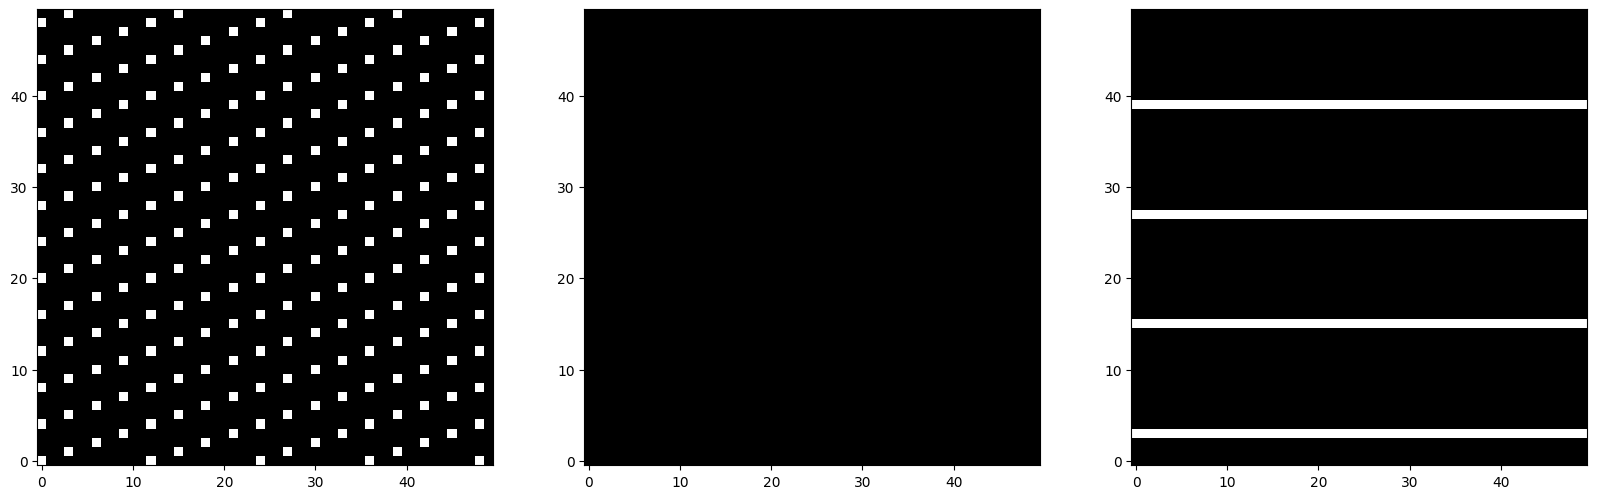

In [117]:
shape=(1,)+t1map.shape
# sampling_pattern=torch.zeros(shape)
# sampling_pattern[:,:,::4,::4]=1
#sampling_pattern[:,20:30,16:26]=1

#caipi 4by3
etl=torch.zeros(12,ny).to(device0)
etl[0,::4]=1
etl[3,1::4]=1
etl[6,2::4]=1
etl[9,3::4]=1
kyz=etl.repeat(ny//12,1)
kyz=torch.cat((kyz,etl[:ny-kyz.shape[0],:]),dim=0)
# plt.imshow(kyz)
# plt.show()

caipi_mask=kyz.unsqueeze(0).repeat(nx,1,1)
print(caipi_mask.shape)

SACshow(caipi_mask.cpu().numpy())

sampling_pattern=caipi_mask.unsqueeze(0)

In [118]:
pIni_path='./pIni-from-ROITrained.npz'
#pIni_path='../HolisticMRI/InitialPulse/pIni_OV90.npz'
model=End2EndModel(tissue_path,pIni_path,sampling_pattern,iv,checkpoint_savepth='./checkpoint/jonhead_caipi/',noise_level=5e-4)

niter=2
n_rf=2
n_gr=2
[opt_pulse,optInfos]=model.optimize_parameters(niter,n_rf,n_gr,doSave=True)


====== Initial loss:-26.581552505493164

#iter	 ‖ elapsed time	 ‖ error	 ‖ total loss	 ‖ avg loss
rf-loop 2
1	 | 150.765	 | -3.156e+01	 | -3.156e+01	 | -1.150e-02
1	 | 214.432	 | -3.163e+01	 | -3.163e+01	 | -1.153e-02
gr-loop 2
1	 | 278.128	 | -3.161e+01	 | -3.161e+01	 | -1.152e-02
1	 | 322.738	 | -3.168e+01	 | -3.168e+01	 | -1.155e-02
Checkpoint saved at: ./checkpoint/jonhead_caipi/iter_1_checkpoint.pth
rf-loop 2
2	 | 475.746	 | -3.166e+01	 | -3.166e+01	 | -1.154e-02
gr-loop 2
2	 | 513.833	 | -3.170e+01	 | -3.170e+01	 | -1.155e-02
2	 | 603.038	 | -3.178e+01	 | -3.178e+01	 | -1.158e-02
Checkpoint saved at: ./checkpoint/jonhead_caipi/iter_2_checkpoint.pth

====== Results: ======

#iter	 ‖ elapsed time	 ‖ error	 ‖ total loss	 ‖ avg loss
2	 | 603.050	 | -3.178e+01	 | -3.178e+01	 | -1.158e-02


In [18]:
model.save_network('./checkpoint/uniformM0/',3)

Checkpoint saved at: ./checkpoint/uniformM0/iter_3_checkpoint.pth


Resume training

In [119]:
pIni_path='./pIni-from-ROITrained.npz'
model=End2EndModel(tissue_path,pIni_path,sampling_pattern,iv,checkpoint_savepth='./checkpoint/jonhead_caipi/',noise_level=5e-4)
model.load_network('./checkpoint/jonhead_caipi/iter_2_checkpoint.pth')

niter=6
n_rf=2
n_gr=2
[opt_pulse,optInfos]=model.optimize_parameters(niter,n_rf,n_gr,iter_start=2,doSave=True)

/tmp/ipykernel_1915678/3681332758.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


Checkpoint loaded from: ./checkpoint/jonhead_caipi/iter_2_checkpoint.pth
====== Initial loss:-31.703474044799805

#iter	 ‖ elapsed time	 ‖ error	 ‖ total loss	 ‖ avg loss
rf-loop 2
3	 | 87.079	 | -3.168e+01	 | -3.168e+01	 | -1.155e-02
3	 | 163.462	 | -3.165e+01	 | -3.165e+01	 | -1.153e-02
gr-loop 2
4	 | 316.429	 | -3.176e+01	 | -3.176e+01	 | -1.157e-02
4	 | 386.452	 | -3.166e+01	 | -3.166e+01	 | -1.154e-02
gr-loop 2
4	 | 437.414	 | -3.170e+01	 | -3.170e+01	 | -1.155e-02
4	 | 482.028	 | -3.173e+01	 | -3.173e+01	 | -1.156e-02
Checkpoint saved at: ./checkpoint/jonhead_caipi/iter_4_checkpoint.pth
rf-loop 2
5	 | 564.768	 | -3.153e+01	 | -3.153e+01	 | -1.149e-02
5	 | 666.744	 | -3.159e+01	 | -3.159e+01	 | -1.151e-02
gr-loop 2
5	 | 768.689	 | -3.158e+01	 | -3.158e+01	 | -1.151e-02
5	 | 819.658	 | -3.158e+01	 | -3.158e+01	 | -1.151e-02
Checkpoint saved at: ./checkpoint/jonhead_caipi/iter_5_checkpoint.pth
rf-loop 2
6	 | 877.148	 | -3.157e+01	 | -3.157e+01	 | -1.151e-02
6	 | 953.529	 | -3.171e+0

## Design ROI-GUIDE for Jon's Head

In [9]:
import nibabel as nib

In [43]:
file='/home/yonglihe/jon_scan/jon_siemems_scan_flipped_synthseg.nii.gz'
label_nii=nib.load(file)

label=label_nii.get_fdata()

label=label.transpose((0,2,1))
label=np.flip(label,axis=(2))

label.shape

(176, 256, 256)

In [44]:
import sys
sys.path.append('/home/yonglihe/github/my_utils')
from vis import SACshow

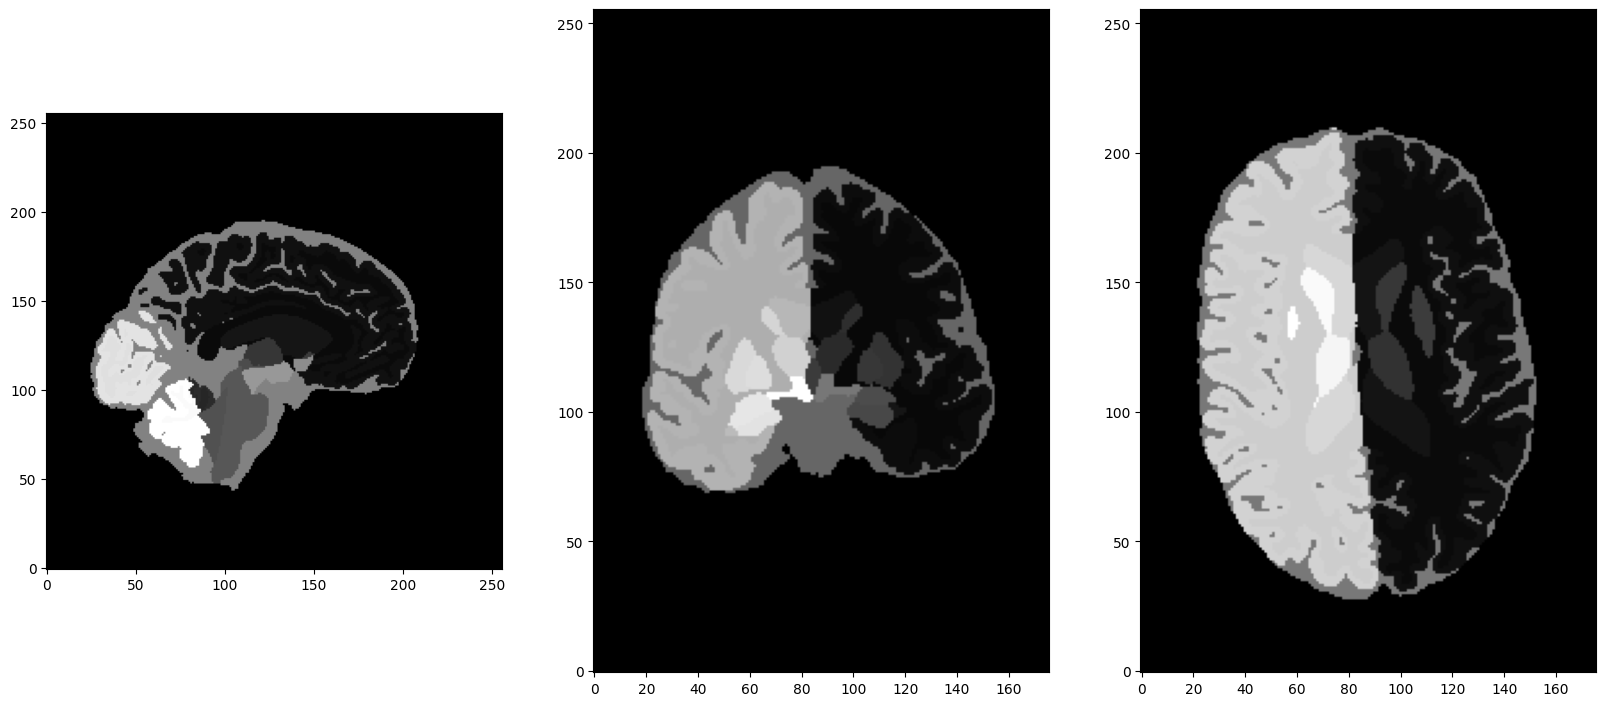

In [45]:
SACshow(label,pad=False)

Processing: crop --> pad --> recon

In [46]:
def crop_image(array):
    r""" central crop an image array so that there's no zero padding
    Inputs:
    - ``array``: 3D numpy array (label map)
    """
    positive=np.where(array>0)
    lf=np.min(positive[0]) #left
    rg=np.max(positive[0]) #right
    po=np.min(positive[1]) #posterior
    an=np.max(positive[1]) #anterior
    inf=np.min(positive[2]) #inferior
    sup=np.max(positive[2]) #superior

    crop_array=array[lf:rg+1,po:an+1,inf:sup+1]
    return crop_array, [lf,rg,po,an,inf,sup]

[label_crop,idx]=crop_image(label)

In [47]:
label_crop.shape

(143, 187, 152)

In [48]:
idx

[16, 158, 23, 209, 44, 195]

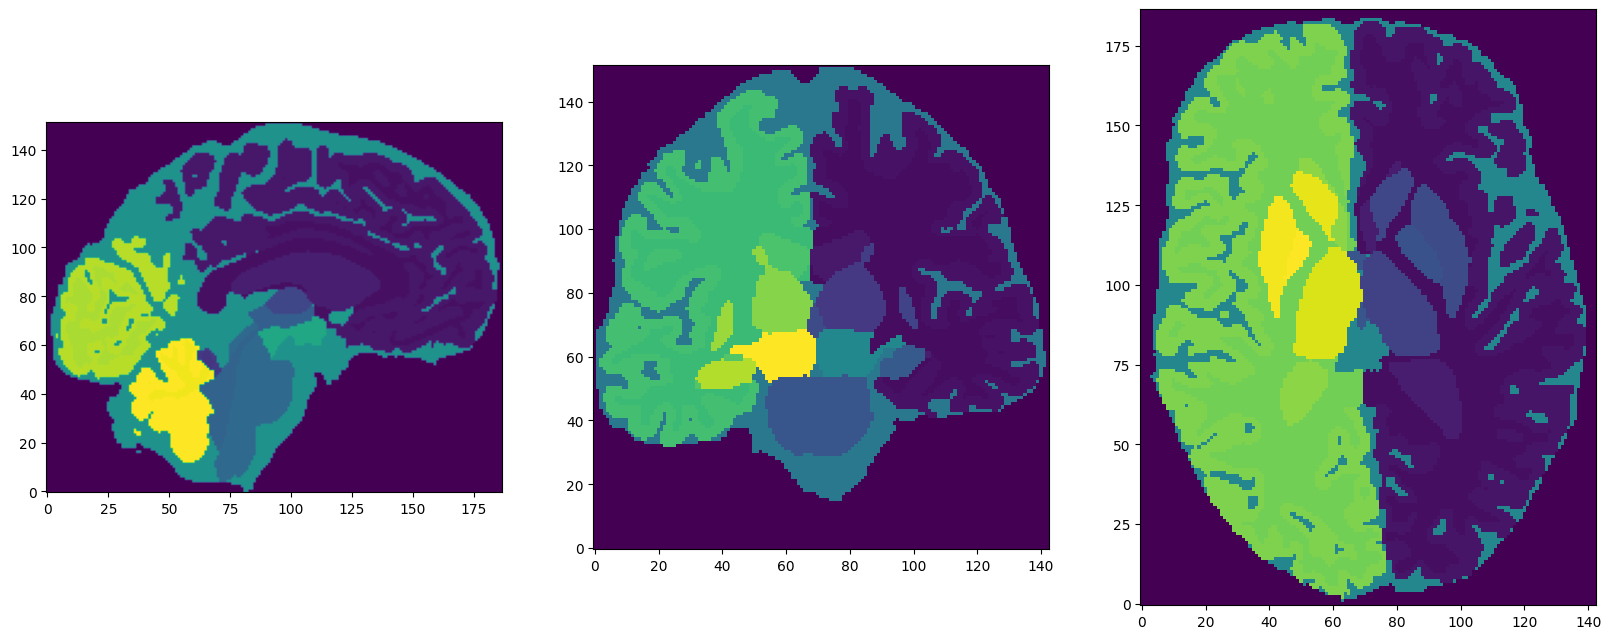

In [50]:
SACshow(label_crop,pad=False,cmap='viridis')

In [63]:
image_file='/home/yonglihe/jon_scan/jon_siemems_scan_flipped.nii.gz'
mprage_nii=nib.load(image_file)

mprage=mprage_nii.get_fdata()

mprage=mprage.transpose((0,2,1))
mprage=np.flip(mprage,axis=(2))

mprage.shape

(176, 256, 256)

In [98]:
## Crop mprage
mprage_crop=mprage[idx[0]-7:idx[1]+1+7,idx[2]-9:idx[3]+1+15,0:idx[5]+1+13]
mprage_crop.shape

(157, 211, 209)

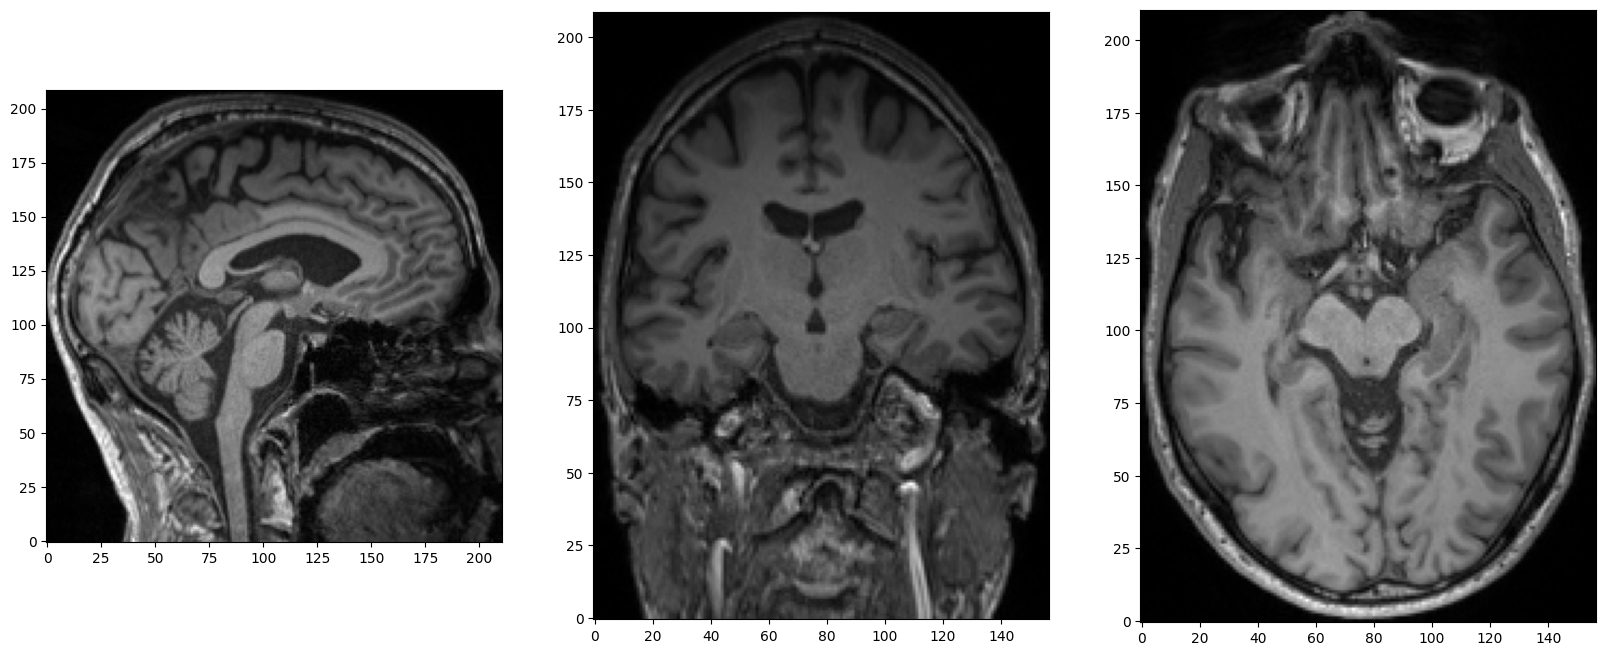

In [99]:
SACshow(mprage_crop,pad=False)

signal mean:219.8060733000741
background mean:1.9890853922703897	 background std:1.1903006167210646


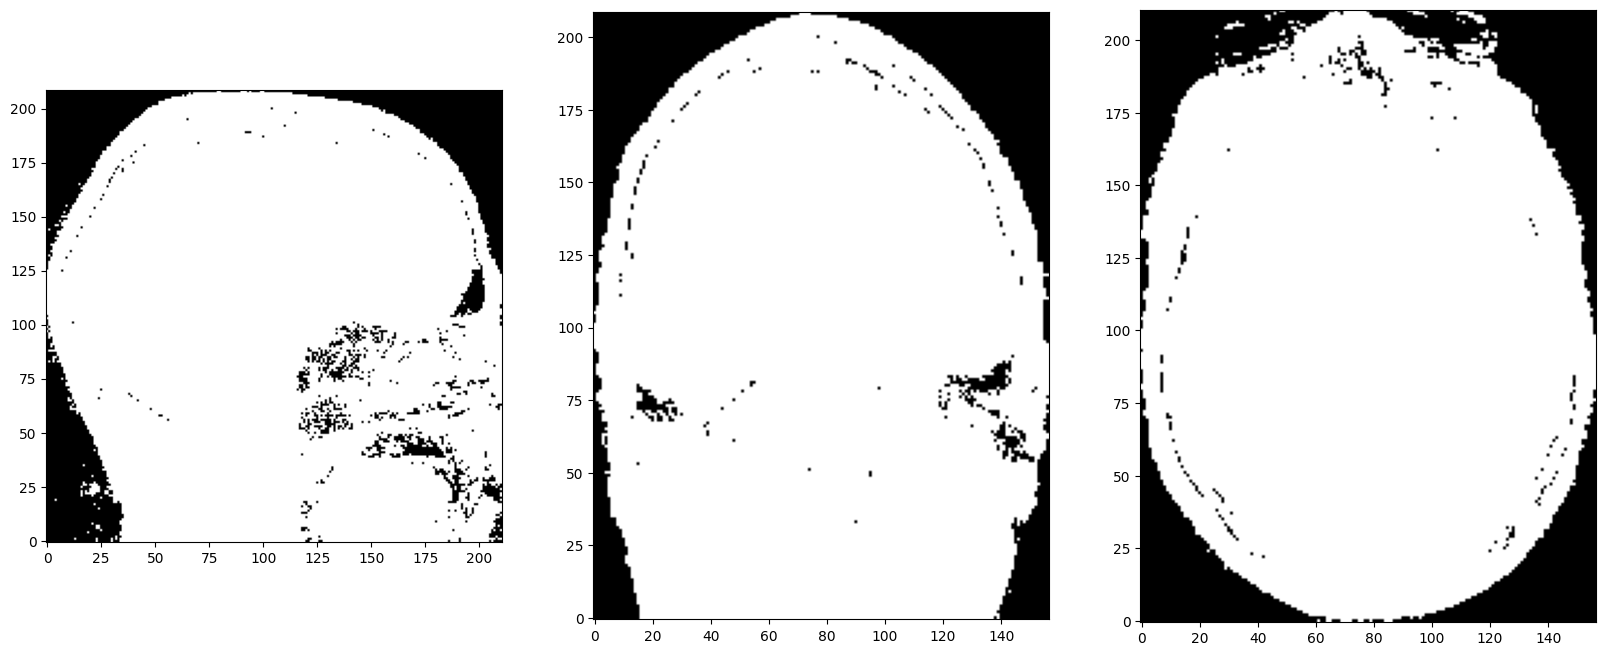

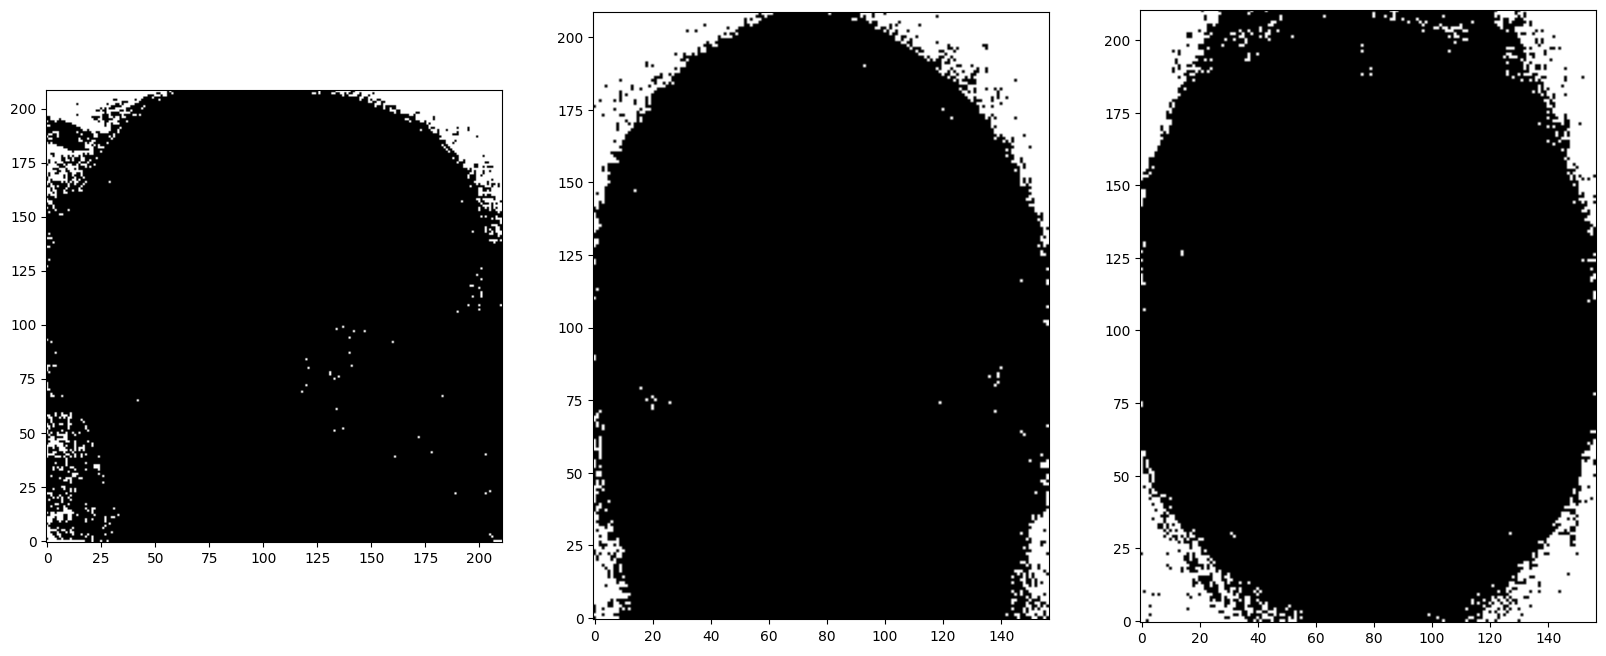

In [154]:
mprage_crop[5,:,105]
SACshow(mprage_crop>20,pad=False)
SACshow(mprage_crop<5,pad=False)

image_support=mprage_crop>20 #brain support
image_bg=mprage_crop<5 #back ground

signal_mean=np.sum(mprage_crop[image_support])/np.sum(image_support.astype(int))
bg_std=np.std(mprage_crop[image_bg])
bg_mean=np.mean(mprage_crop[image_bg])
print(f"signal mean:{signal_mean}\nbackground mean:{bg_mean}\t background std:{bg_std}")

In [100]:
from scipy.ndimage import zoom
import scipy

In [101]:
[bnx,bny,bnz]=mprage_crop.shape #this is the actual size of the brain

In [102]:
def pad_image(img):
    nx,ny,nz=img.shape
    nmax=max(img.shape)
    size_diff=np.array([nmax-nx,nmax-ny,nmax-nz])

    pad1=((size_diff[0]//2,size_diff[0]//2) if size_diff[0]%2==0 else (size_diff[0]//2,size_diff[0]//2+1))
    pad2=((size_diff[1]//2,size_diff[1]//2) if size_diff[1]%2==0 else (size_diff[1]//2,size_diff[1]//2+1))
    pad3=((size_diff[2]//2,size_diff[2]//2) if size_diff[2]%2==0 else (size_diff[2]//2,size_diff[2]//2+1))
    padded_data=np.pad(img,(pad1, pad2, pad3), mode='constant', constant_values=0)
    return padded_data

mprage_pad=pad_image(mprage_crop)
mprage_pad.shape

(211, 211, 211)

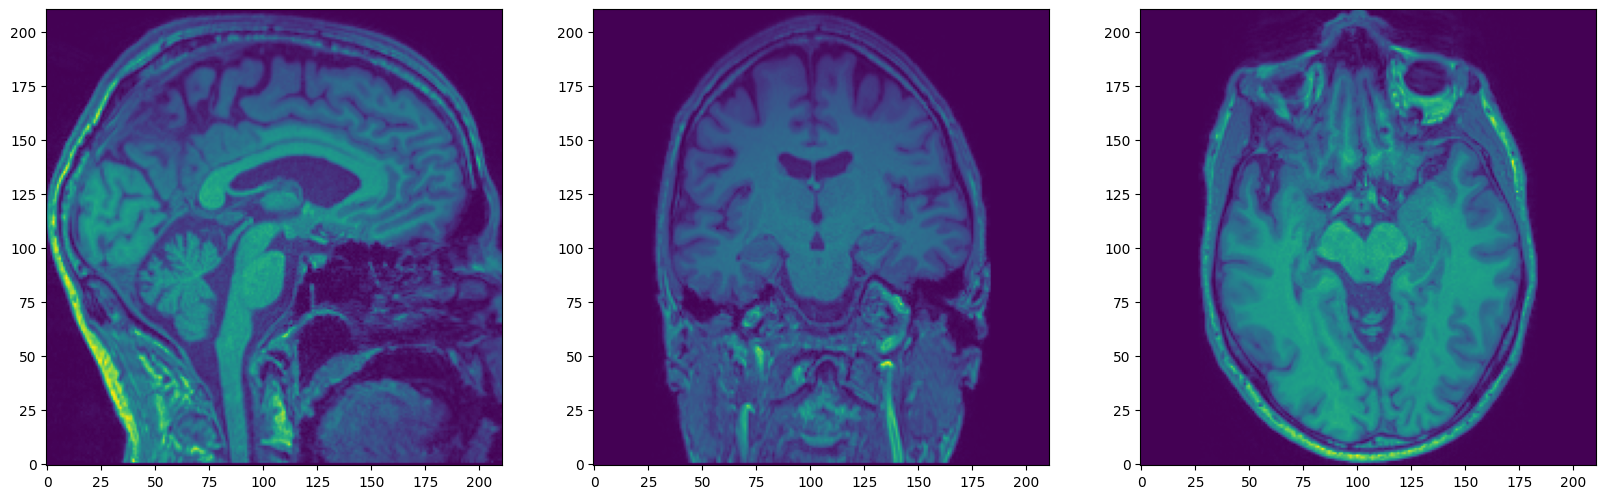

In [103]:
SACshow(mprage_pad,pad=False,cmap='viridis')

In [116]:
smap_mat=scipy.io.loadmat('../../jon_scan/smap_jonhead.mat')
smap=smap_mat['smap']
smap=np.transpose(smap,(3,0,1,2))

zoom_factor=[1]+list(np.array(mprage_pad.shape)/np.array(smap.shape[1:]))
smap_zoom=zoom(smap,zoom_factor)
smap_zoom.shape

(32, 211, 211, 211)

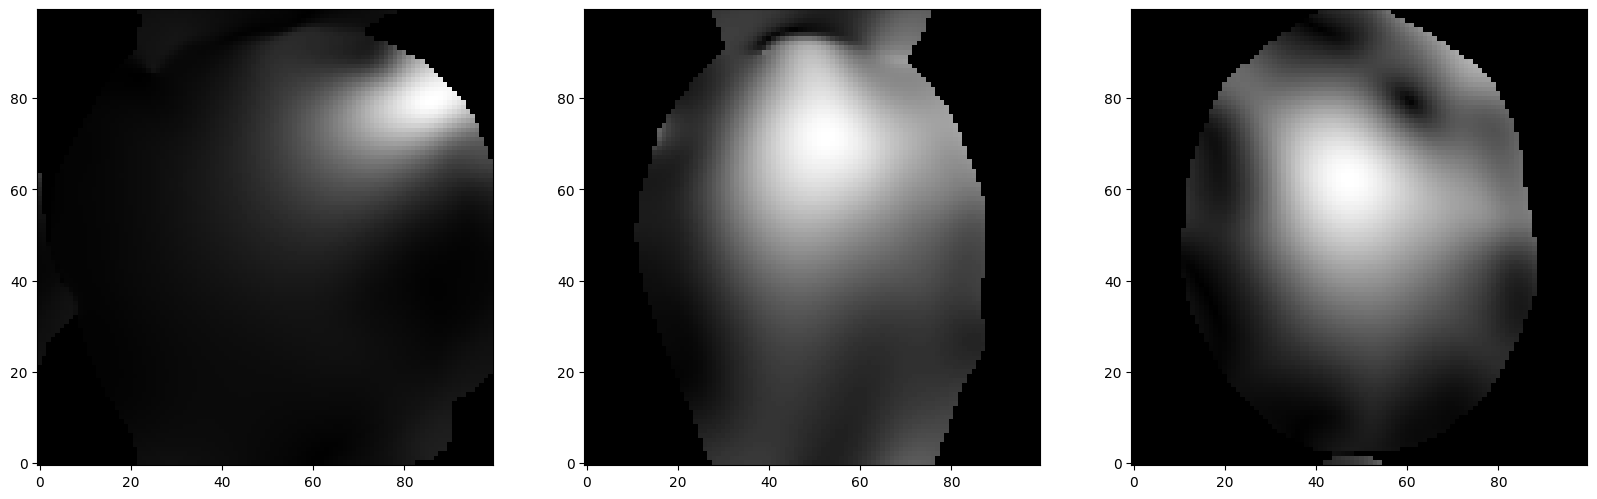

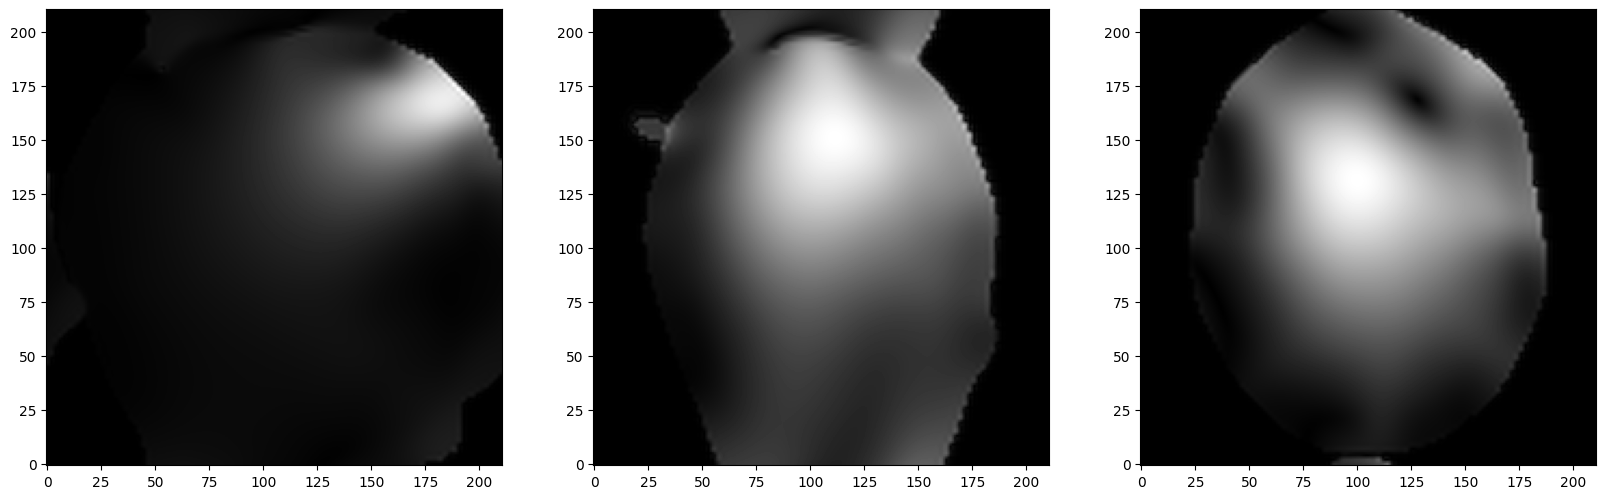

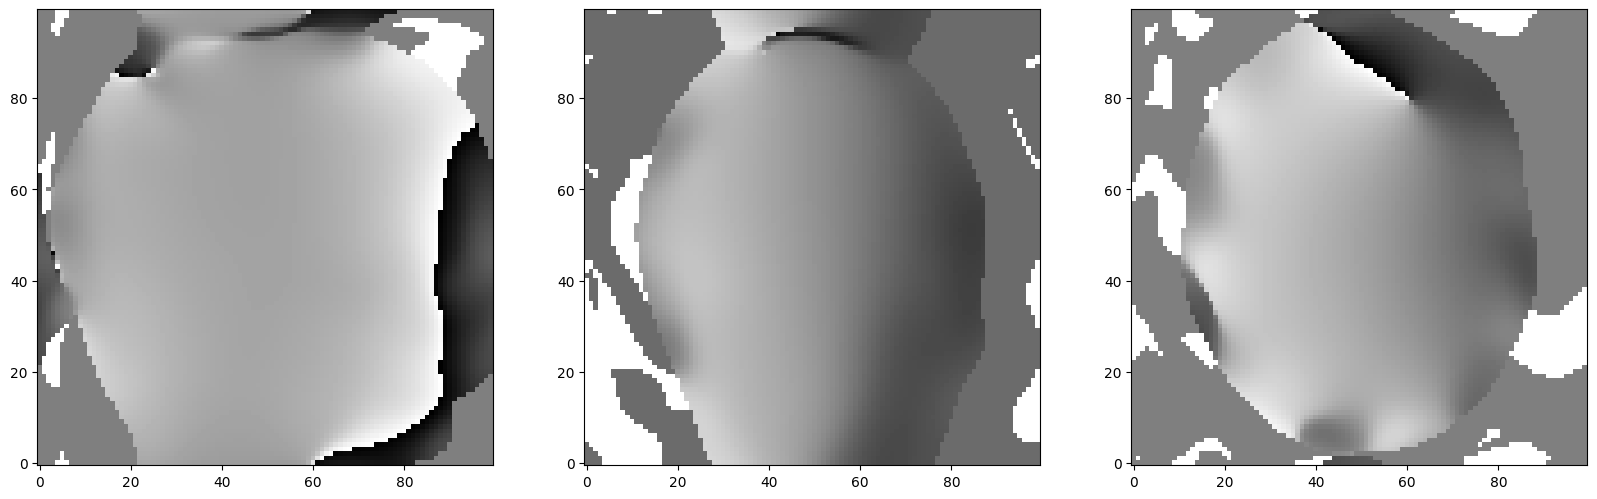

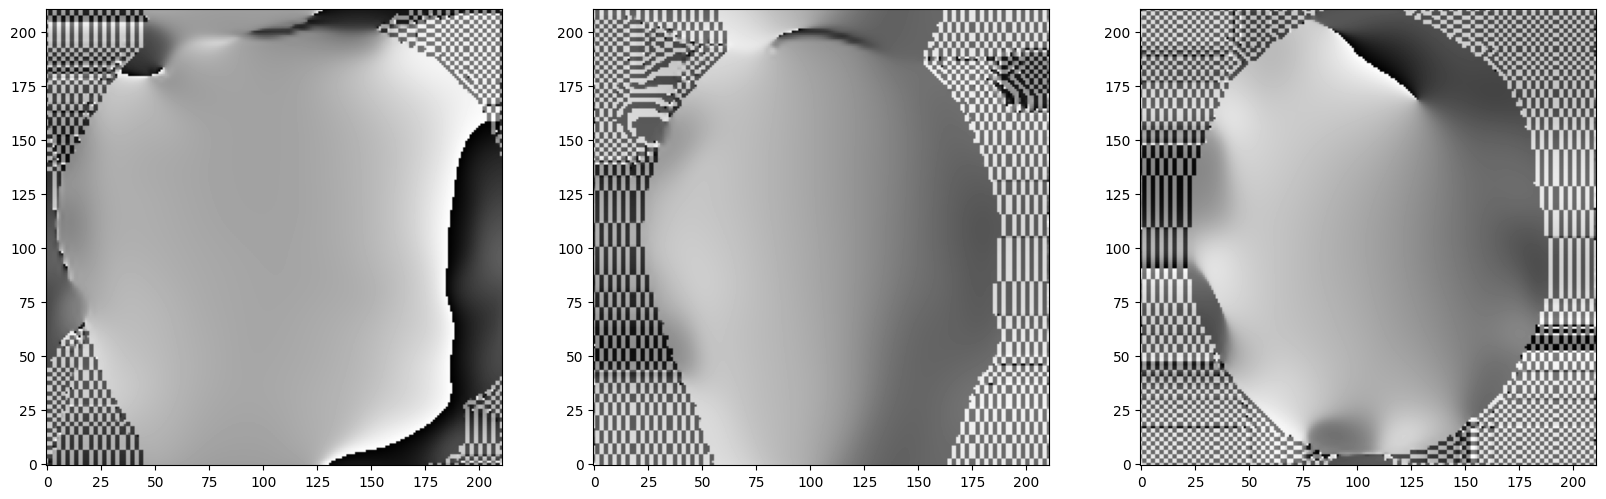

In [117]:
SACshow(np.abs(smap[25,...]))
SACshow(np.abs(smap_zoom[25,...]))

SACshow(np.angle(smap[25,...]))
SACshow(np.angle(smap_zoom[25,...]))

In [118]:
scipy.io.savemat('./jonhead_smap_highres.mat',{'smap':smap_zoom})

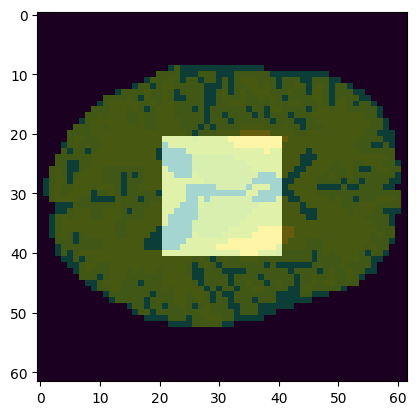

In [107]:
# plt.figure(figsize=(6, 6))
plt.imshow(Ireal_jonhead3.cpu().numpy()[:,:,31])  # Display the first image in grayscale
plt.imshow(iv.cpu().numpy()[:,:,31], alpha=0.6,cmap='gray')  
plt.show()

In [104]:
Ireal_jonhead=mprage_pad
Ireal_jonhead.shape

(211, 211, 211)

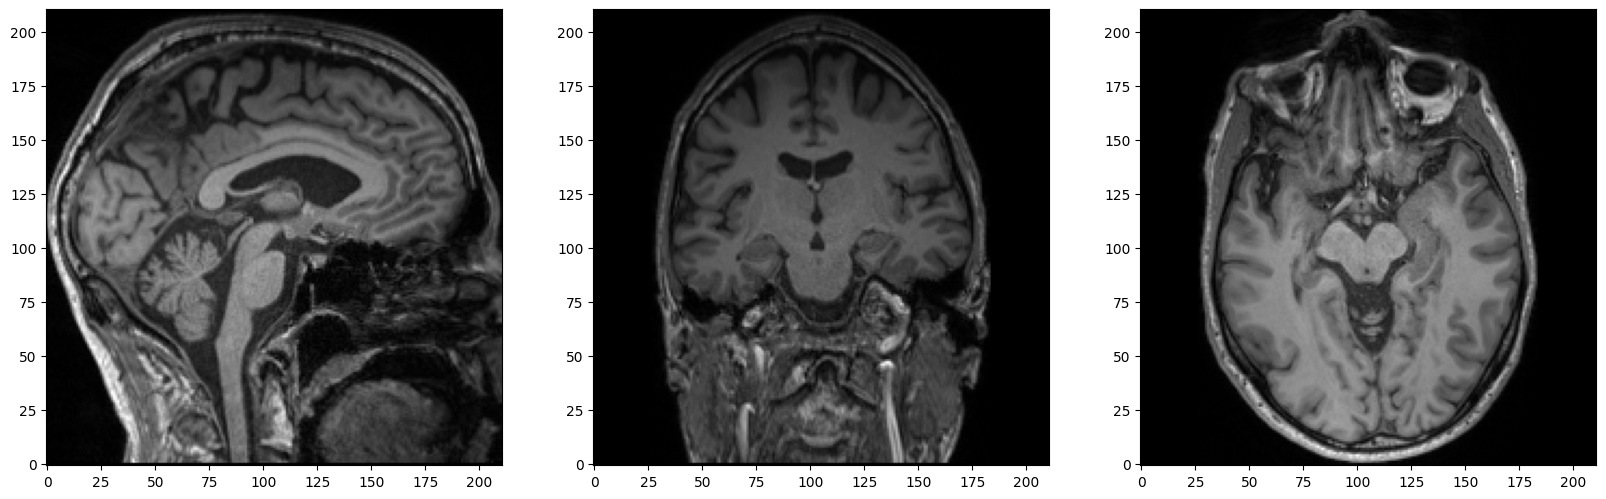

In [105]:
SACshow(Ireal_jonhead,pad=False)

In [ ]:
smap=scipy.io.loadmat('./jonhead_smap_highres.mat')['smap']
smap=torch.tensor(smap).to(device0)
[nc,nx,ny,nz]=smap.shape

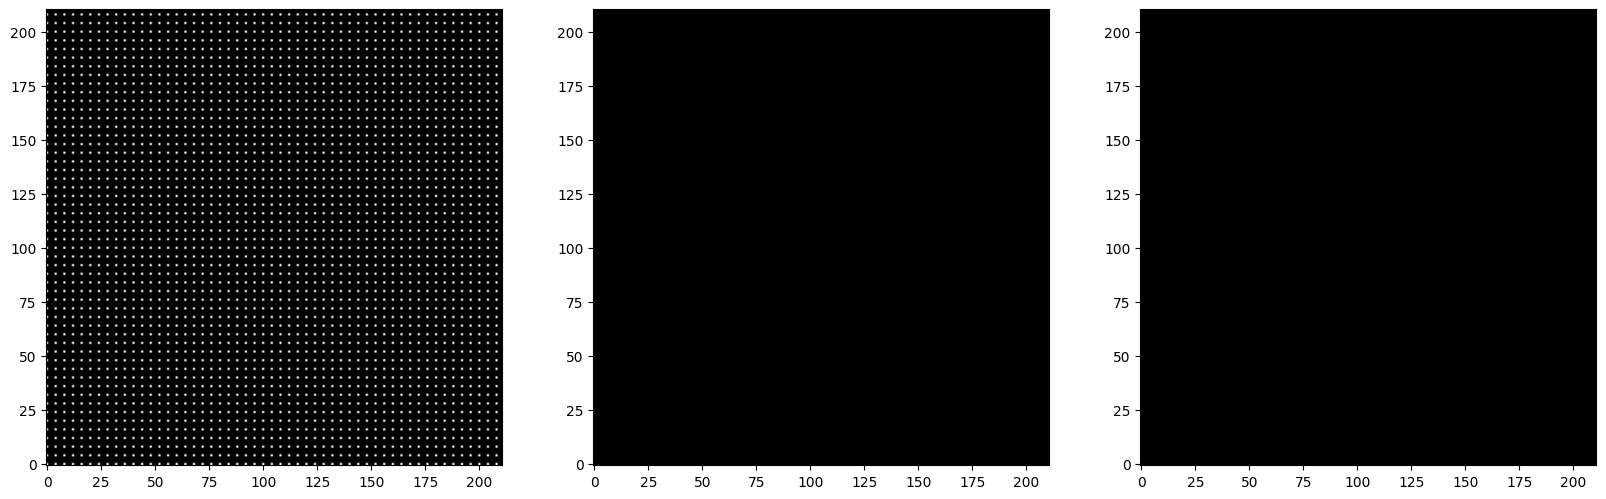

In [170]:
#sampling pattern
mask = torch.zeros(nx,ny,nz).to(device0)
mask[:,0:ny:4,0:nz:4]=1
# etl=torch.zeros(16,ny).to(device0)
# etl[0,::4]=1
# etl[4,1::4]=1
# etl[8,2::4]=1
# etl[12,3::4]=1
# kyz=etl.repeat(ny//16,1)
# kyz=torch.cat((kyz,etl[:ny-kyz.shape[0],:]),dim=0)
# # plt.imshow(kyz)
# # plt.show()

# caipi_mask=kyz.unsqueeze(0).repeat(nx,1,1)
# caipi_mask.shape
# SACshow(caipi_mask.cpu().numpy())
SACshow(mask.cpu().numpy())

In [171]:
#Sop=Sense(smap.unsqueeze(0),caipi_mask.unsqueeze(0))
Sop=Sense(smap.unsqueeze(0),mask.unsqueeze(0))

In [172]:
Mz=torch.tensor(Ireal_jonhead).to(device0) #[nbatch,1,nx,ny,nz]
Mz=Mz.unsqueeze(0).unsqueeze(0)
Mz.shape

torch.Size([1, 1, 211, 211, 211])

In [173]:
kunder=Sop*Mz
#noise_level=1e-2#5e-6

#####
pos=torch.abs(kunder)>1e-5
nM=torch.sum(pos.int())
k_signal_mean=torch.sum(torch.abs(kunder))/nM
noise_mean=0.01*k_signal_mean
noise_std=0.005*k_signal_mean
#####

kunder=kunder+(noise_mean+noise_std*torch.randn_like(kunder))
Iunder=Sop.H*kunder
Iunder3=Iunder.squeeze(0).squeeze(0) #[nx,ny,nz]

I = Identity(Mz.shape)
CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
Irecon = CG_solver.run(Iunder,Iunder)

In [174]:
pos=torch.abs(kunder)>1e-5
nM=torch.sum(pos.int())
torch.sum(torch.abs(kunder))/nM

tensor(0.2771, device='cuda:0', dtype=torch.float64)

In [175]:
Irecon3=Irecon.squeeze(0).squeeze(0)

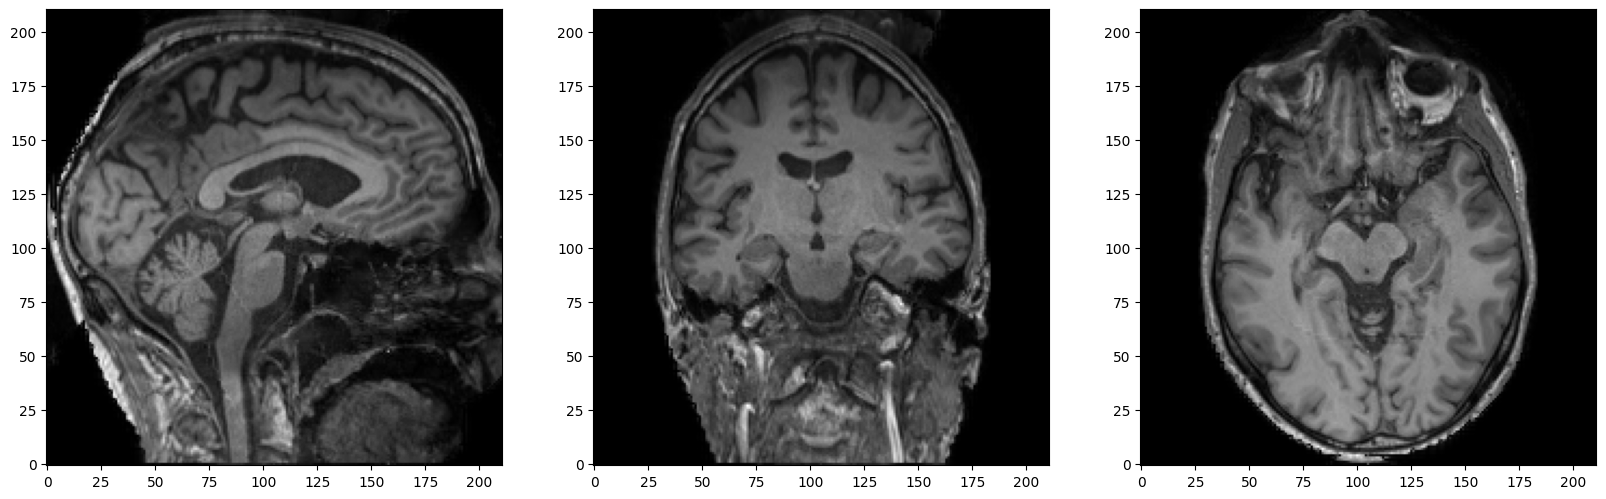

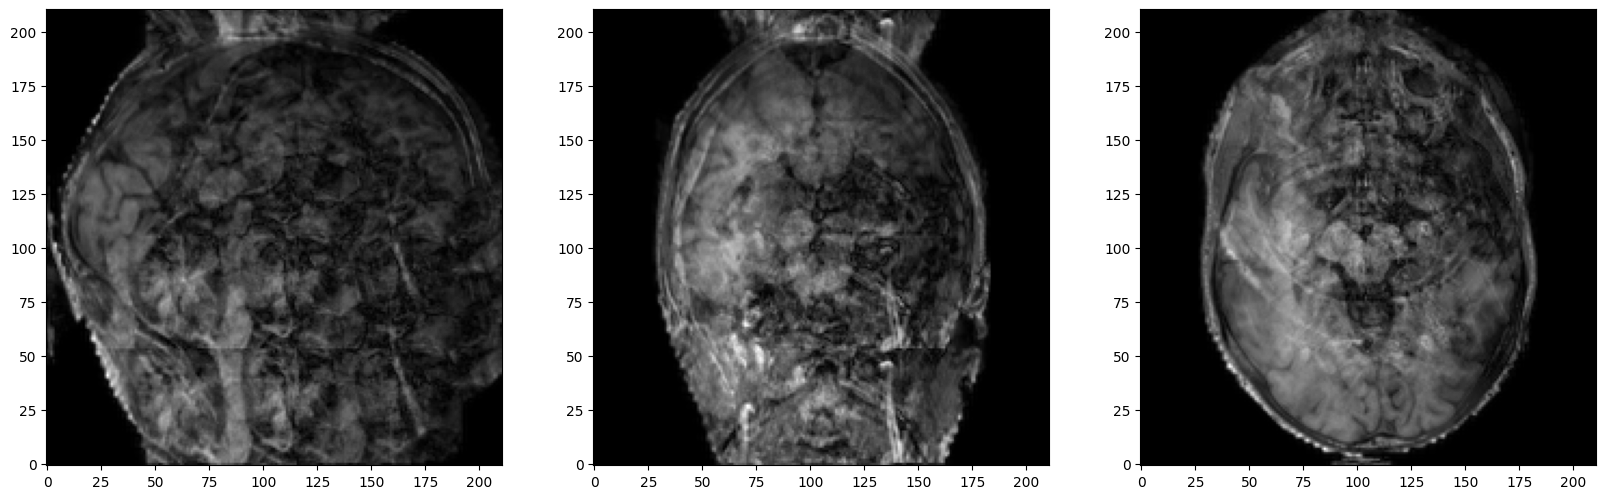

In [176]:
SACshow(abs(Irecon3).cpu().numpy())
SACshow(abs(Iunder3).cpu().numpy())

In [177]:
iv=torch.zeros_like(caipi_mask)
iv[nx//2-nx//4+5:nx//2+nx//4-5,ny//2-ny//4+5:ny//2+ny//4-5,nz//2-nz//4+5:nz//2+nz//4-5]=1
psnr=PSNR(torch.abs(torch.tensor(Ireal_jonhead).to(device0)),torch.abs(Irecon3),iv)

In [178]:
psnr

tensor(34.2819, device='cuda:0', dtype=torch.float64)

In [103]:
Ireal_jonhead3=Ireal_jonhead[0,...]
Ireal_norm=(torch.abs(Ireal_jonhead3)-torch.abs(Ireal_jonhead3).min())/(torch.abs(Ireal_jonhead3).quantile(0.9999)-torch.abs(Ireal_jonhead3).min())
Irecon_norm=(torch.abs(Irecon3)-torch.abs(Irecon3).min())/(torch.abs(Irecon3).quantile(0.9999)-torch.abs(Irecon3).min())

In [104]:
psnr=PSNR(Ireal_norm,Irecon_norm,iv)

In [105]:
psnr

tensor(29.8802, device='cuda:0')

In [58]:
np.savez('./jonhead_tissuemap.npz',t1map=t1map,t2map=t2map,pdmap=pdmap)